# Modern architectures for CIFAR-10 classification

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model, Sequential
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [3]:
# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 600)
pd.options.display.width = 120
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

This will help with replicability, but does not control all aspects of randomness in the code.

In [5]:
np.random.seed()

### Read the data

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
print(X_train.min(), X_train.max())
print(np.unique(y_train))

0 255
[0 1 2 3 4 5 6 7 8 9]


#### We'll use a smaller version of the data to speed up the training process.

In [9]:
num_train = 25000
num_test = 8000
X_train = X_train[:num_train]
y_train = y_train[:num_train]
X_test = X_test[:num_test]
y_test = y_test[:num_test]

### Preprocess the data

In [10]:
# from integers in [0,255] to float in [0,1]
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32') / 255

# one hot encoding
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000, 32, 32, 3)
(25000, 10)
(8000, 32, 32, 3)
(8000, 10)


Confirming that the training labels are 1-hot encoded.

In [12]:
print(y_train[:5])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Create the baseline CNN model

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# classification part
model.add(layers.Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                1

### Create Chollet's CNN model with residual connections, batch normalization, and depthwise separable convolutions

In [15]:
data_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

In [16]:
inputs = Input(shape=X_train.shape[1:])
x = data_augmentation(inputs)                                     
 
x = layers.experimental.preprocessing.Rescaling(1./255)(x)  
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)
 
for size in [32, 64, 128, 256, 512]:  
    residual = x
 
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])
  
x = layers.GlobalAveragePooling2D()(x)      
x = layers.Dropout(0.5)(x)                   
outputs = layers.Dense(10, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['sequential_1[0][0]']           
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 32)   2400        ['rescaling[0][0]']              
                                                                                              

### Compile and train the model

In [18]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
391/391 [==============================] - 31s 49ms/step - loss: 1.6815 - accuracy: 0.3807 - val_loss: 2.5771 - val_accuracy: 0.0986
Epoch 2/50
391/391 [==============================] - 20s 51ms/step - loss: 1.4416 - accuracy: 0.4777 - val_loss: 1.6405 - val_accuracy: 0.3945
Epoch 3/50
391/391 [==============================] - 18s 47ms/step - loss: 1.3364 - accuracy: 0.5258 - val_loss: 1.5828 - val_accuracy: 0.4791
Epoch 4/50
391/391 [==============================] - 18s 47ms/step - loss: 1.2620 - accuracy: 0.5481 - val_loss: 1.2351 - val_accuracy: 0.5711
Epoch 5/50
391/391 [==============================] - 18s 46ms/step - loss: 1.1922 - accuracy: 0.5770 - val_loss: 1.2145 - val_accuracy: 0.5771
Epoch 6/50
391/391 [==============================] - 20s 51ms/step - loss: 1.1487 - accuracy: 0.5931 - val_loss: 1.4099 - val_accuracy: 0.5585
Epoch 7/50
391/391 [==============================] - 20s 51ms/step - loss: 1.1047 - accuracy: 0.6134 - val_loss: 1.4493 - val_accuracy:

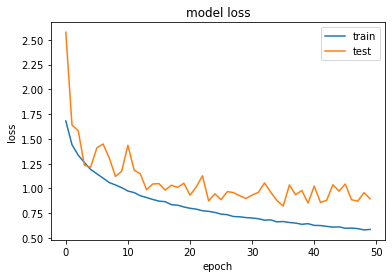

In [19]:
plot_metric(history)

## Experiments

### Experiment 1: Batch normalization 

Train the first, simple model.  Then, add batch normalization and see how your validation accuracy changes.

### Experiment 2: Depthwise separable convolution

Starting again with the original simple model, try replacing the Conv2D layers with depthwise separable convolution.  How much smaller is the modified model?  How much faster does it train?  How does the validation accuracy change?

Chollet discusses the value of "ablation studies".  In such a study, you remove parts from a system and see the impact on performance.  The following questions are in that spirit.

### Experiment 3
: Remove batch normalization

What is the impact on performance if batch normalization is removed?

Remember, the issue is not just final validation accuracy, but the speed of training.

### Experiment 4: Use regular convolution instead of depthwise separable convolution

### Experiment 5: Remove the residual connections

### Other experiments:

If you still have time, retain all features, but reduce the number of blocks.